# 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

p538(557)~

In [1]:
import warnings
warnings.filterwarnings('ignore')

<br>

## 10.1 대회 소개

- Mercari Price Suggestion Challenge는 캐글에서 진행된 Challenge
- 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제
- 제공되는 데이터 세트는 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성
- Mercari사는 이러한 데이터를 기반으로 제품 예상 가격을 판매자들에게 제공하고자 한다.
- 이와 같은 프로세스를 구현하기 위해 판매자는 제품명, 브랜드명, 카테고리, 제품 설명 등 다양한 속성 정보를 입력
- ML 모델은 이 속성에 따라 제품의 예측 가격을 판매자에게 자동으로 제공할 수 있다.

<br>

### 10.1.1 데이터 세트 다운로드

- [다운로드 링크](https://www.kaggle.com/c/mercari-price-suggestion-challenge/data)

<br>

### 10.1.2 데이터 세트 속성

- `train_id` : 데이터 ID
- `name` : 제품명
- `item_condition_id` : 판매자가 제공하는 제품 상태
- `category_name` : 카테고리명
- `brand_name` : 브랜드 이름
- `price` : 제품 가격, 예측을 위한 **타깃 속성**
- `shipping` : 배송비 모류 여부
  - `1` : 무료 (판매자가 지불)
  - `0` : 유로 (구매자가 지불)
- `item_description` : 제품에 대한 설명

- `price`가 예측해야 할 타깃 값이다.
- 회귀로 피처를 학습한 뒤 `price`를 예측하는 문제
- Mercari Price Suggestion이 기존 회귀 예제와 다른 점은 `item_description`과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 휘귀를 수행한다는 점이다.

<br>

## 10.2 데이터 전처리

### 10.2.1 데이터셋 로드

- 필요한 라이브러리와 `mercari_train.tsv` 데이터를 DataFrame으로 로딩
- 데이터를 간략하게 확인

In [3]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('./data/Mercari/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


- 1482535개의 레코드를 가지고 있는 데이터 세트

<br>

### 10.2.2 피처 타입 및 Nul 여부 확인

In [4]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


<br>

**`brand_name`**

- `brand_name` 컬럼의 경우 매우 많은 Null값을 가지고 있음
  - 전체 1482535건 중에 849853건만 Not null이다.
- `brand_name`은 가격에 영향을 미치는 중요 요인으로 판단되지만, 많은 데이터가 Null로 되어 있다.

<br>

**`category_name`**

- `category_name`은 약 6300건의 null 데이터를 가지고 있음

<br>

**`item_description`**

- `item_description`의 null값은 4건으로 미비하다.

<br>

이 Null 데이터는 이후에 적절한 문자열로 치환

<br>

### 10.2.3 Target 컬럼 분포 확인

- Target 값인 `price` 컬럼의 데이터 분포도 확인
- 회귀에서 Target 값의 정규 분포도는 매우 중요하다.
- 왜곡돼 있을 경우 보통 로그를 씌워서 변환하면 대부분 정규 분포의 형태를 가지게 된다.

- `price` 컬럼의 데이터 값 분포도 확인

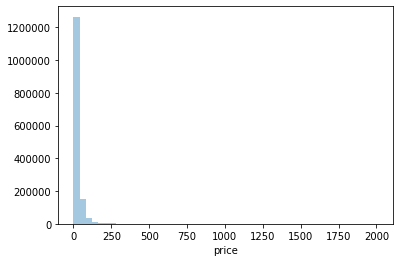

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)
plt.show()

- `price` 값이 비교적 적은 가격을 가진 데이터 값에 왜곡되어 분포돼 있다.

<br>

### 10.2.4 타깃 컬럼 로그 변환

- `Price` 컬럼을 로그 값으로 변환한 뒤 분포도 다시 확인

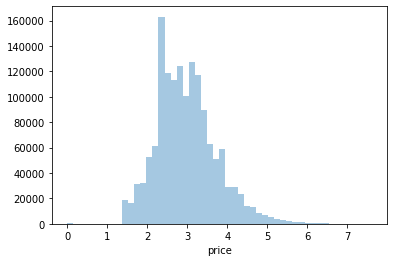

In [6]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)
plt.show()

- 로그 값으로 변환하면 `price` 값이 비교적 정규 분포에 가까운 데이터를 이루게 된다.
- 데이터 세트의 `price` 컬럼을 원래 값에서 로그로 변환된 값으로 변경

In [7]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

<br>

### 10.2.5 피처 분포 확인

- 다른 피처의 값도 확인

<br>

#### 10.2.5.1 `shipping`

In [8]:
mercari_df['shipping'].value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

- `Shipping` 컬럼은 **배송비 유무**
- 값이 비교적 균일하다.

<br>

#### 10.2.5.2 `item_condition_id`

In [9]:
mercari_df['item_condition_id'].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

- `Item_condition_id`는 **판매자가 제공하는 제품 상태**
- 각 값이 의미하는 바는 캐글에 기재돼 있지 않아서 알 수 없지만, 1,2,3 값이 주를 이루고 있음

<br>

#### 10.2.5.3 `item_description`

- `item_description` 컬럼은 Null 값은 별로 없음
- description에 대한 별도 설명이 없는 경우 'No description yet' 값으로 돼 있다.
- 이러한 값이 얼마나 있는 지 확인

In [10]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

- `item_description`이 'No description yet`으로 돼 있는 행은 82489건이다.
- 'No description yet'의 경우도 Null과 마찬가지로 의미 있는 속성값으로 사용될 수 없으므로 적절한 값으로 변경해야 한다.

<br>

#### 10.2.5.4 `category_name`

- `category_name`은 '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있다.
  - ex) 'Men/Tops/T-shirts'
    - 대분류 : 'Men'
    - 중분류 : 'Tops'
    - 소분류 : 'T-shirts'
- `category_name`은 텍스트이므로 피처 추출 시 `tokenizer`를 '/'로 하여 단어를 분리해 벡터화할 수 도 있음
- 여기서는 `category_name`의 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습

- `category_name` 컬럼을 '/'를 기준으로 대, 중, 소분류로 효과적으로 분리해 내기 위해 별도의 `split_cat()` 함수를 생성
- 이 함수를 DataFrame의 `apply lambda` 식에 적용

- `category_name` 컬럼은 Null값을 약 6300여 건을 가지고 있으므로 이에 유의하면서 분리해야 한다.

In [11]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성
# 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        # category_name이 Null이 아닌 경우에 split('/')를 이용해 대, 중, 소 분류를 분리
        return category_name.split('/')
    except:
        # category_name이 Null일 경우에는 split() 함수가 Error를 발생하므로 예외 처리
        return ['Other_Null','Other_Null','Other_Null']

<br>

- 대, 중, 소 컬럼은 `mercari_df`에서 `cat_dae`, `cat_jung`, `cat_so`로 부여

- 판다스의 `apply lambda`로 반환되는 데이터 세트가 리스트를 요소로 가지고 있는 데 이를 다시 `cat_dae`, `cat_jung`, `cat_so`의 DataFrame 컬럼으로 분리해야 한다.
- 이 부분은 다음 코드에서처럼 `zip`과 `*`를 `apply lambda` 식에 적용하면 여러 개의 컬럼으로 간단하게 분리할 수 있다.

In [12]:
# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 컬럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
    zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

In [13]:
# 대분류만 값의 유형과 건수를 확인
# 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts(), '\n')
print('중분류 유형 :\n', mercari_df['cat_jung'].nunique(), '\n')
print('소분류 유형 :\n', mercari_df['cat_so'].nunique(), '\n')

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64 

중분류 유형 :
 114 

소분류 유형 :
 871 



- 대분류의 경우 Women, Beauty, Kids 등의 분류가 매우 많다.
- 중분류 유형은 114개, 소분류는 871개로 구성

<br>

#### 10.2.5.5 `brand_name`, `category_name`, `item_description` Null값 처리

- `brand_name`, `category_name`, `item_description` 컬럼의 Null값은 일괄적으로 `'Other Null'`로 동일하게 변경  
(`brand_name`은 `price` 값 결정에 영향을 많이 줄 것으로 판단되지만, Null값이 너무 많다.)

- `fillna()`를 적용한 뒤에 각 컬럼별로 Null 값이 없는 지 다음과 같이 `mercari_df.isnull().sum()`을 호출해 확인

In [14]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

In [15]:
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

<br>

## 10.3 피처 인코딩과 피처 벡터화

- 피처 인코딩 : 컬럼을 숫자형 코드 값으로 인코딩
- 피처 벡터화 : 텍스트 컬럼에 대해서는 피처 벡터화 변환을 적용

<br>

### 10.3.1 피처 변환 방법 검토

- 데이터 세트의 문자열 컬럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 컬럼을 선별
- 이 피처를 어떤 방식으로 변환할 지 검토한 후에 추후에 일괄적으로 전체 속성의 변환 작업을 적용

<br>

#### 10.3.1.1 인코딩 방식 - 원-핫 인코딩

- Mercari Price Suggestion에서 예측 모델은 price 값, 즉 상품 가격을 예측해야 하므로 **회귀 모델**을 기반으로 한다.
- **선형 회귀 모델**과 **회귀 트리 모델**을 모두 적용할 예정
- 선형 회귀의 경우 **원-핫 인코딩 적용이 훨씬 선호됨**  
$\Rightarrow$ 인코딩할 피처는 모두 원-핫 인코딩을 적용

<br>

#### 10.3.1.2 피처 벡터화

- 비교적 짧은 텍스트의 경우 $\rightarrow$ Count 기반의 벡터화 적용
- 긴 텍스트 $\rightarrow$ TF-IDF 기반의 벡터화 적용

<br>

### 10.3.2 컬럼별 인코딩 및 피처 벡터화 방법 결정

#### 10.3.2.1 `brand_name`

- 상품의 브랜드명 (상품명이 아님)
- 상품 브랜드명이 어떤 유형으로 되어 있는 지 유형 건수와 대표적인 브랜드명을 5개 확인

In [16]:
print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 :\n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : 4810
brand name sample 5건 :
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


- `brand_name`의 경우 대부분 명료한 문자열로 되어 있음
- 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환을 적용하면 된다.
- `brand_name`의 종류가 4810건 $\rightarrow$ 원-핫 인코딩으로 변환하기에 다소 많아 보이나 본 예제의 ML 모델 구축상 큰 문제는 없다.  
$\Rightarrow$ **`brand_name`은 원-핫 인코딩 변환**

<br>

#### 10.3.2.2 `name`

- 상품명

In [17]:
print('name의 종류 개수 :', mercari_df['name'].nunique())
print('name sample 10건 :\n', mercari_df['name'].value_counts()[:10])

name의 종류 개수 : 1225273
name sample 10건 :
 Bundle                 2232
Reserved                453
Converse                445
BUNDLE                  418
Dress                   410
Coach purse             404
Lularoe TC leggings     396
Romper                  353
Nike                    340
Vans                    334
Name: name, dtype: int64


- `name` 속성의 경우 종류가 매우 많다. (1,225,273가지)
- 전체 데이터가 1,482,535개 이므로 개별적으로 거의 고유한 상품명을 가지고 있다.
- `name` 속성은 유형이 매우 많고, 적은 단위 위주의 텍스트 형태로 되어 있다.  
$\Rightarrow$ **`name`은 Count 기반으로 피처 벡터화 변환**을 적용

<br>

#### 10.3.2.3 `category_name`

- 이전에 전처리를 통해서 해당 컬럼은 아래와 같이 대, 중, 소 분류 세 개의 컬럼으로 분리
  - `cat_dae`
  - `cat_jung`
  - `cat_so`  
$\Rightarrow$ **`cat_dae`, `cat_jung`, `cat_so` 컬럼도 원-핫 인코딩을 적용**

<br>

#### 10.3.2.4 `shipping`

- 배송비 무료 여부
- 0과 1, 두 가지 유형의 값을 가지고 있음  
$\Rightarrow$ **원-핫 인코딩 적용**

<br>

#### 10.3.2.5 `item_condition_id`

- 상품 상태
- 1, 2, 3, 4, 5의 다섯 가지 유형의 값을 가지고 있음  
$\Rightarrow$ **원-핫 인코딩 적용**

<br>

#### 10.3.2.6 `item_description`

- 상품에 대한 간단 설명
- 데이터 세트에서 가장 긴 텍스트를 가지고 있다.

- 해당 컬럼의 평균 문자열 크기와 2개 정도의 텍스트 추출

In [18]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

item_description 평균 문자열 크기: 145.7113889385411


In [19]:
mercari_df['item_description'][:2]

0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

- 평균 문자열이 145자로 비교적 큼  
$\Rightarrow$ **TF-IDF로 피처 벡터화**

<br>

#### 10.3.2.7 요약

<div style="text-align: left; margin-left: 20px;">
    <img src="./images/Ch08/10/img001.jpg" width="600px"/>
</div>

<br>

### 10.3.3 주요 컬럼 인코딩 및 피처 벡터화 변환

#### 10.3.3.1 `name`, `item_description` 피처 벡터화

- `name` 컬럼
  - `CountVectorizer`로 변환
  - 기본 파라미터 사용  
  
  
- `item_description` 컬럼
  - `TfidfVectorizer`로 변환
  - 파라미터
    - `max_features=50000`
    - `n_gram_range=(1,3)` (triple gram)
    - `stop_words='english'`

In [20]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000,
                              ngram_range=(1,3),
                              stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape :', X_name.shape)
print('item_description vectorization shape :', X_descp.shape)

name vectorization shape : (1482535, 105757)
item_description vectorization shape : (1482535, 50000)


<br>

#### 10.3.3.2 나머지 컬럼 인코딩

- `CountVectorizer`, `TfidfVectorizer`가 `fit_transform()`을 통해 반환하는 데이터는 **희소 행렬** 형태이다.
- 희소 행렬 객체 변수인 `X_name`과 `X_descp`를 새로 결합해 새로운 데이터 세트로 구성해야 한다.
- 또한 앞으로 인코딩 될 `cat_dae`, `cat_jung`, `cat_so`, `brand_name`, `shipping`, `item_condition_id` 도 모두 `X_name`, `X_descp`와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성돼야 한다.

- 이를 위해서 이 인코딩 대상 컬럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩한 뒤 함께 결합한다.

- 사이킷런은 원-핫 인코딩을 위해 `OneHotEncoder`와 `LabelBinarizer` 클래스를 제공한다.
- 이 중 `LabelBinarizer` 클래스는 희소 행렬 형태의 원-핫 인코딩 변환을 지원한다.
  - 생성 시 `sparse_out=True`로 파라미터 설정
- 모든 인코딩 대상 컬럼은 `LabelBinarizer`를 이용해 희소 행렬 형태의 원-핫 인코딩으로 변환

- 개별 컬럼으로 만들어진 희소 행렬은 사이파이 패키지 `sparse` 모듈의 `hstack()` 함수를 이용해 결합
  - `hstack()` : 희소 행렬을 손쉽게 컬럼 레벨로 결합할 수 있게 해준다.

- 먼저 인코딩 대상 컬럼을 모두 `LabelBinarizer`로 원-핫 인코딩 변환 실시

In [21]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

<br>

- 제대로 변환됐는 지 생성된 인코딩 데이터 세트의 타입과 shape을 확인

In [22]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print()
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>

X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입이다.

- 그리고 `brand_name` 컬럼의 경우 값의 유형이 4810개이므로 이를 원-핫 인코딩으로 변환한 `X_brand_shape`의 경우 4810개의 인코딩 컬럼을 가지게 된다.

- `X_cat_so`의 경우도 871개의 인코딩 컬럼을 가진다.

- 인코딩 컬럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 컬럼과 함께 결합되므로 크게 문제될 것은 없다.

<br>

#### 10.3.3.3 데이터 세트 결합

- 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 `hstack()`을 이용해 모두 결합
- 결합된 데이터는 Mercari Price Suggestion을 위한 기반 데이터 세트로 사용됨
- 여기서는 결합한 데이터의 타입과 크기만 확인하고 메모리에서 삭제
  - 만들어진 결합 데이터가 비교적 많은 메모리를 잡아먹기 때문에 개인용 PC에서 메모리 오류가 발생할 수 있다.
  - `del '객체 변수명'`rhk `gc.collect()`로 결합 데이터를 메모리에서 삭제
  - 추후에 다양한 모델을 적용하므로 그때마다 다시 결합해 해당 데이터 세트를 이용

In [23]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


0

- `hstack()`으로 결합한 데이터 세트는 `csr_matrix` 타입이며, 총 161,569개의 피처를 가지게 된다.

<br>

## 10.4 릿지 회귀 모델 구축 및 평가

- 여러 알고리즘 모델과 희소 생렬을 변환하고 예측 성능을 비교하면서 테스트 수행  
$\Rightarrow$ 수행에 필요한 로직을 함수화

<br>

### 10.4.1 모델 평가(Evaluation) 로직 함수화

- 적용할 평가 지표 : 캐글에서 제시한 **RMSLE(Root Mean Square Logarithmic Error)** 방식
- RMSLE는 RMSE와 유사하나 오류 값에 로그를 취해 RMSE를 구하는 방식
- 낮은 가격(price)보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해서 이 방식을 도입

$$
\epsilon = \sqrt{ {1 \over n} \sum_{i=1}^n \left( log \left( p_i + 1 \right) - log \left( a_i + 1 \right) \right)^2 }
$$

- 별도의 RMSLE를 구하는 함수를 `rmsle(y, y_pred)`로 생성

**주의 사항**

- 원본 데이터의 `price` 컬럼의 값은 왜곡된 데이터 분포를 가지고 있음
- 이를 정규 분포 형태로 유도하기 위해 로그 값을 취해 변환함
- 즉, 학습할 모델이 사용할 `price` 값은 로그 값으로 변환된 `price` 값이므로 예측도 당연히 로그로 변환한 데이터 값 수준의 `price` 값을 예측할 것
- 따라서 학습 모델을 이용한 예측된 `price` 값은 다시 **로그의 역변환인 지수(Exponential) 변환**을 수행해 원복해야 한다.

- 이렇게 원복된 데이터를 기반으로 RMSLE를 적용할 수 있도록 `evaluate_org_price(y_test, preds)` 함수를 생성

In [29]:
def rmsle(y, y_pred):
    
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

<br>

### 10.4.2 학습용 데이터 생성, 모델 학습 / 예측 로직 함수화

#### 10.4.2.1 `model_train_predict()`

- `model` : 사이킷런의 회귀 estimator 객체
- `matrix_list` : 최종 데이터 세트로 결합할 희소 행렬 리스트

- 평가 데이터 세트는 `train_test_split()`을 이용해 전체 데이터의 20% 사용

In [27]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()
    
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                        test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train
    gc.collect()
    
    return preds, y_test

<br>

### 10.4.3 Ridge 이용 Mercari Price 회귀 예측

- 수행 전에 Mercari 상품 가격 예측에 `item_description`과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는 지 확인
- `item_description` 속성의 피처 벡터화 데이터가 포함되지 않았을 때와 포함됐을 때의 예측 성능을 다음 예제 코드와 같이 비교

In [30]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값 :', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값 : 0.5021728034748267


In [31]:
sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값 :', evaluate_org_price(y_test, linear_preds))

Item Description을 포함한 rmsle 값 : 0.47122050042890895


- `item_description`을 포함했을 때 rmsle 값이 많이 감소  
$\Rightarrow$ `item_description` 영향이 중요함을 알 수 있다.

<br>

## 10.5 LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가